# **Tell Me What You Want, I'll Tell You What You Like**

In this file, we try to use the first clustering approach (the basic version) (random exploration)

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [6]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...


## Main code

In [7]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [8]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [9]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20



# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [10]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, tasks = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
# list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n,optimalval, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...


Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 4103
Le max de list_obj est 5460
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x0000026078AE91C0>, <docplex.cp.solution.CpoSolveResult object at 0x000002607392D440>], [<docplex.cp.solution.CpoSolveResult object at 0x000002607999FA40>], [<docplex.cp.solution.CpoSolveResult object at 0x0000026079ECFEC0>, <docplex.cp.solution.CpoSolveResult object at 0x0000026076DDFDC0>, <docplex.cp.solution.CpoSolveResult object at 0x00000260734C0740>], [<docplex.cp.solution.CpoSolveResult object at 0x000002606FCDA6C0>, <docplex.cp.solution.CpoSolveResult object at 0x0000026078FA38C0>, <docplex.cp.solution.CpoSolveResult o

In [11]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, tasks = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    if it > 1:
        model, variables = solver.create_constraints(model, n, m, list_min_obj_global[it-1], T_machine)
    else :
        model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    
    #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    print(len(layers))
    # print(len(layers[i]) for i in range (len(layers)))
        #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5 

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")
        print("Number of clusters :", k)
        print("Number of solutions :", len(data))

        if l > 0:
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            if(len(data)==0):
                continue
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                #------------------ Liste des solutions des clusters de la layer l

                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Ajout des contraintes
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)


#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)

    it += 1


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 2
Number of solutions : 2
-------------- Layer 1 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 2 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 3 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...
The number of solutions generated is : 3917
Objective function : [4103, 4081]
Model solved !

Classing solutions...
Le min de list_obj est 4081
Le max de list_obj est 5480
Solutions classed !

Creating preferences...
Preferences created !
Il y a 

In [12]:
# ####################################################################
# #### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
# ####################################################################

# import clustering as cl
# import decision_tree as dt

# ###  -------------- Iteration of the solver with the preferences
# it = 1
# tps = runtime
# list_min_obj = [min(list_obj)]
# list_min_obj_global = [min(list_obj)]

# criterion = (tps < tps_max) and (it < it_max) 

# # ----------------- Add the preferences to the model
# while criterion :
#     print("\n--------Iteration {}---------".format(it))
#     clf, feuilles_conditions = dt.my_decision_tree(n, m, list_layers)

#     # --------- Call Solver constructor in Solver.py and create the variables of the model
#     model, solver, tasks = fm.initialize_solver(data, n, m, duration)

#     # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
#     variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    
#     order = model.binary_var(name="order")
#     solver.add_variable(order)
#     # --------- Add the new constraints to the model (concerning the order)
#     list_variables = [model.start_of(variables[i//m][i%m]) for i in range(n*m)]
#     constraint_list_of_tree = dt.constraint_tree(order,list_variables, feuilles_conditions)

#     for constraint in constraint_list_of_tree:
#         solver.add_constraint(model, constraint)
#     solver.add_constraint(model, equal(order, 1))

    
    

#     # ------------ Solve the model
#     print("\nSolving the model...")
#     # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
#     model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
#     msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
#     print("The number of solutions generated is :",nb_solution)
#     list = []
#     for sol in msol:
#         list.append(user.objectiveFunction(sol))

#     list_min_obj.append(min(list))
#     print("Objective function :", list_min_obj)

#     # ------------ Display the result
#     fm.display_solution(msol, display_sol)
#     print("Model solved !")

#     # ---------------- Interaction with the user
#     # list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
#     list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, optimalval, m)
#     print("Il y a {} solution(s)".format(len(pref)))

#     list_min_obj_global.append(min(list_obj))
#     print("Objective function global :", list_min_obj_global)

#     # Vector of the start time of each task of each preference
#     starts = user.start_pref(n, m, display_start)

#     # Matrix of the start time of each task of each preference
#     matrix = user.matrix_pref(n, m, display_matrix)

#     # Testing the order of preferences and the differences between solutions
#     fm.test(n, m, user)


# #------------------ Condition d'arrêt ------------------
#     tps += runtime
#     criterion = (tps < tps_max) and (it < it_max)
#     fm.stopCondition(it, it_max, tps, tps_max)

#     it += 1

[4103, 4081, 4322, 4106, 4101, 4204, 3995, 3971, 10744, 3909, 3906, 3917, 4040, 4050, 4078]


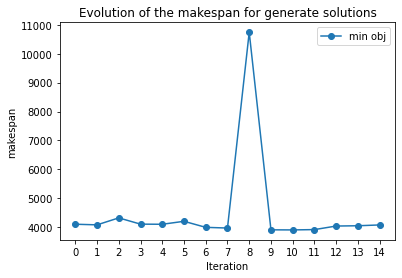

In [13]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[4103, 4081, 4081, 4081, 4081, 4081, 3995, 3971, 3971, 3909, 3906, 3906, 3906, 3906, 3906]


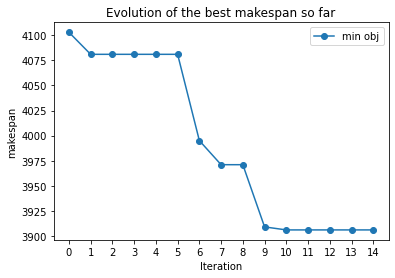

In [14]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

150


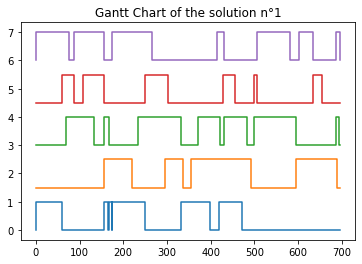

Makespan of the solution n°1 : 696
Regularity of the solution n°1 : 3210
Objective function of the solution n°1 : 2234160


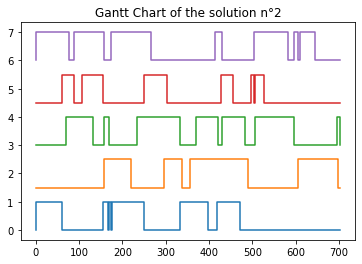

Makespan of the solution n°2 : 703
Regularity of the solution n°2 : 3206
Objective function of the solution n°2 : 2253818


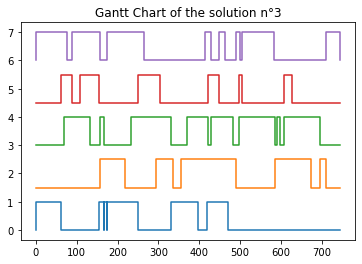

Makespan of the solution n°3 : 745
Regularity of the solution n°3 : 3172
Objective function of the solution n°3 : 2363140


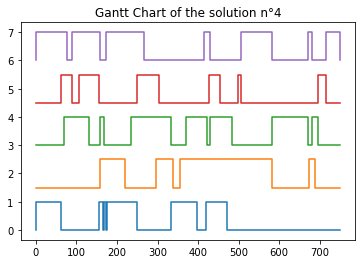

Makespan of the solution n°4 : 750
Regularity of the solution n°4 : 3170
Objective function of the solution n°4 : 2377500


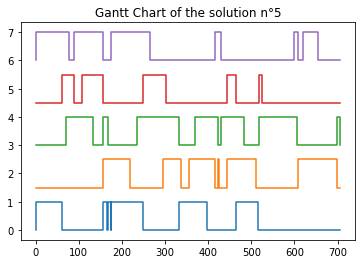

Makespan of the solution n°5 : 706
Regularity of the solution n°5 : 3226
Objective function of the solution n°5 : 2277556


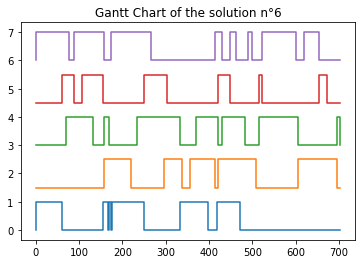

Makespan of the solution n°6 : 703
Regularity of the solution n°6 : 3266
Objective function of the solution n°6 : 2295998


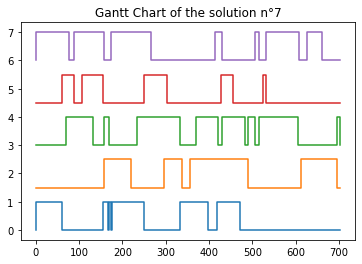

Makespan of the solution n°7 : 703
Regularity of the solution n°7 : 3268
Objective function of the solution n°7 : 2297404


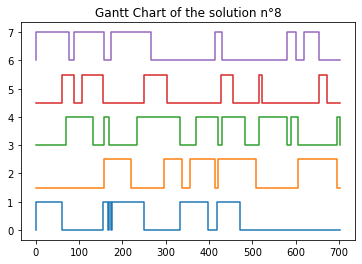

Makespan of the solution n°8 : 703
Regularity of the solution n°8 : 3280
Objective function of the solution n°8 : 2305840


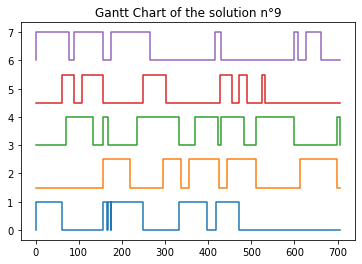

Makespan of the solution n°9 : 706
Regularity of the solution n°9 : 3286
Objective function of the solution n°9 : 2319916


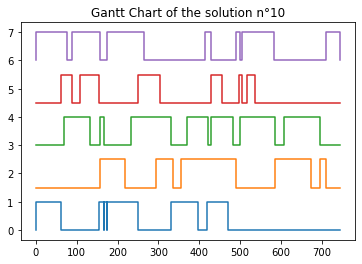

Makespan of the solution n°10 : 745
Regularity of the solution n°10 : 3250
Objective function of the solution n°10 : 2421250


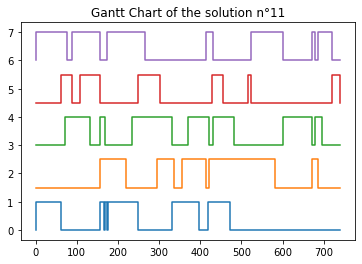

Makespan of the solution n°11 : 740
Regularity of the solution n°11 : 3266
Objective function of the solution n°11 : 2416840


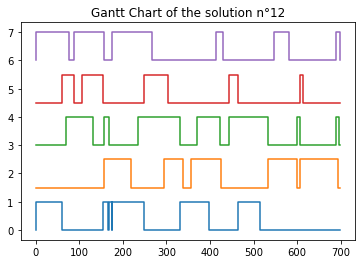

Makespan of the solution n°12 : 699
Regularity of the solution n°12 : 3310
Objective function of the solution n°12 : 2313690


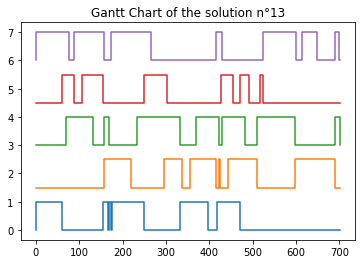

Makespan of the solution n°13 : 702
Regularity of the solution n°13 : 3328
Objective function of the solution n°13 : 2336256


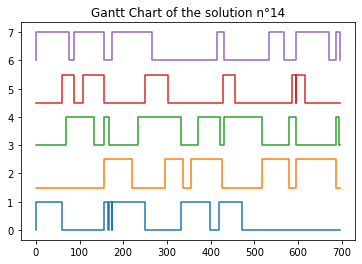

Makespan of the solution n°14 : 696
Regularity of the solution n°14 : 3344
Objective function of the solution n°14 : 2327424


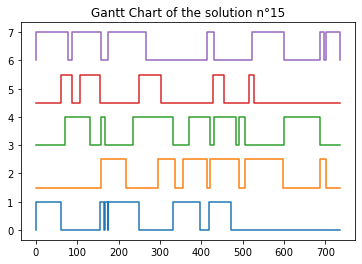

Makespan of the solution n°15 : 736
Regularity of the solution n°15 : 3314
Objective function of the solution n°15 : 2439104


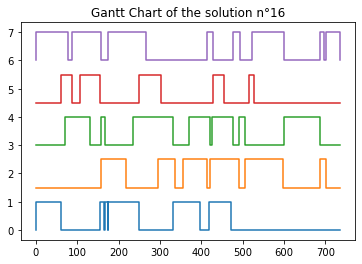

Makespan of the solution n°16 : 736
Regularity of the solution n°16 : 3314
Objective function of the solution n°16 : 2439104


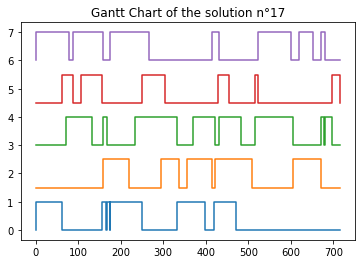

Makespan of the solution n°17 : 716
Regularity of the solution n°17 : 3352
Objective function of the solution n°17 : 2400032


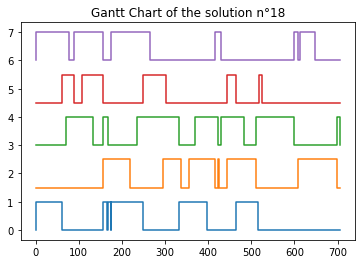

Makespan of the solution n°18 : 706
Regularity of the solution n°18 : 3364
Objective function of the solution n°18 : 2374984


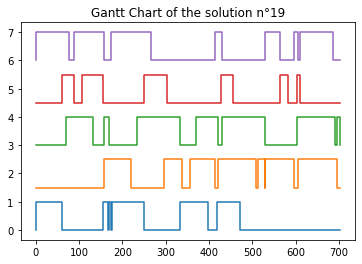

Makespan of the solution n°19 : 703
Regularity of the solution n°19 : 3370
Objective function of the solution n°19 : 2369110


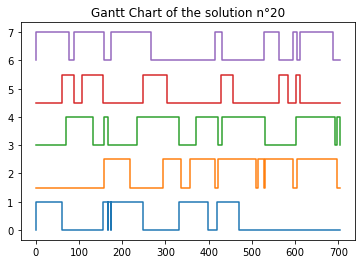

Makespan of the solution n°20 : 704
Regularity of the solution n°20 : 3374
Objective function of the solution n°20 : 2375296


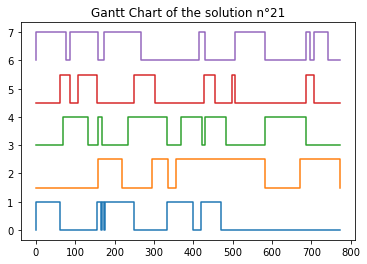

Makespan of the solution n°21 : 773
Regularity of the solution n°21 : 3308
Objective function of the solution n°21 : 2557084


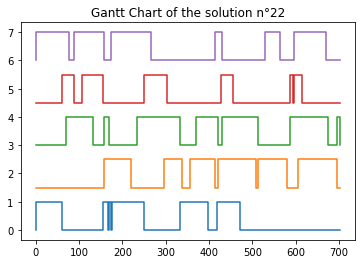

Makespan of the solution n°22 : 703
Regularity of the solution n°22 : 3388
Objective function of the solution n°22 : 2381764


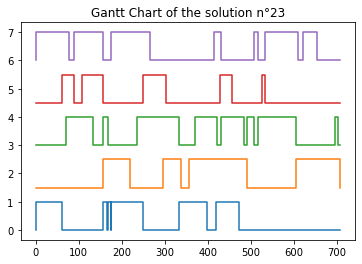

Makespan of the solution n°23 : 707
Regularity of the solution n°23 : 3394
Objective function of the solution n°23 : 2399558


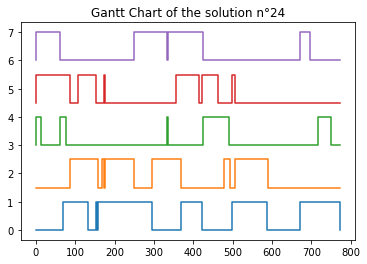

Makespan of the solution n°24 : 773
Regularity of the solution n°24 : 3330
Objective function of the solution n°24 : 2574090


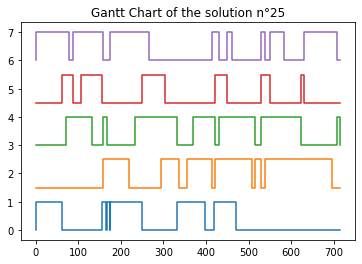

Makespan of the solution n°25 : 715
Regularity of the solution n°25 : 3390
Objective function of the solution n°25 : 2423850


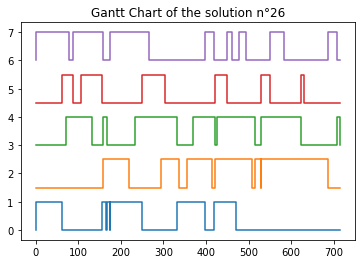

Makespan of the solution n°26 : 715
Regularity of the solution n°26 : 3390
Objective function of the solution n°26 : 2423850


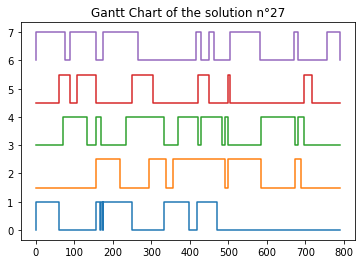

Makespan of the solution n°27 : 790
Regularity of the solution n°27 : 3316
Objective function of the solution n°27 : 2619640


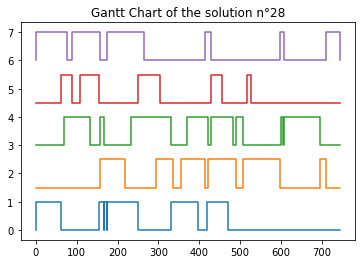

Makespan of the solution n°28 : 745
Regularity of the solution n°28 : 3386
Objective function of the solution n°28 : 2522570


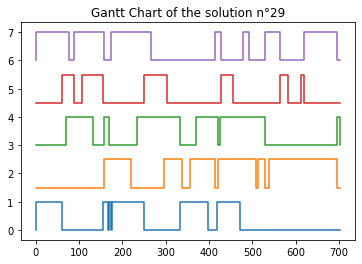

Makespan of the solution n°29 : 703
Regularity of the solution n°29 : 3442
Objective function of the solution n°29 : 2419726


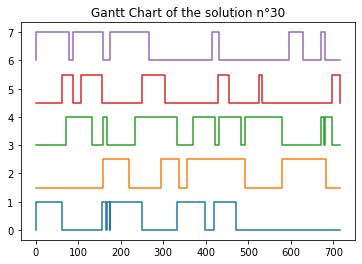

Makespan of the solution n°30 : 716
Regularity of the solution n°30 : 3448
Objective function of the solution n°30 : 2468768


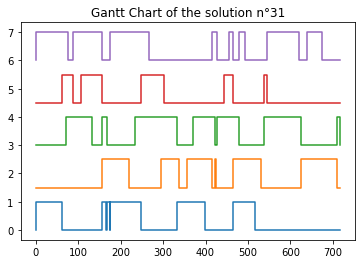

Makespan of the solution n°31 : 717
Regularity of the solution n°31 : 3452
Objective function of the solution n°31 : 2475084


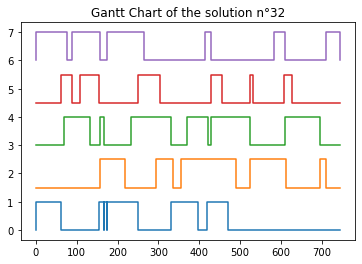

Makespan of the solution n°32 : 745
Regularity of the solution n°32 : 3426
Objective function of the solution n°32 : 2552370


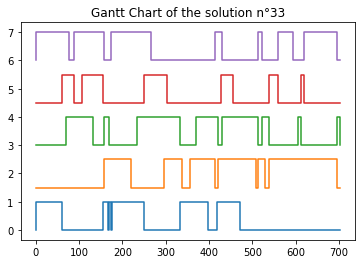

Makespan of the solution n°33 : 703
Regularity of the solution n°33 : 3482
Objective function of the solution n°33 : 2447846


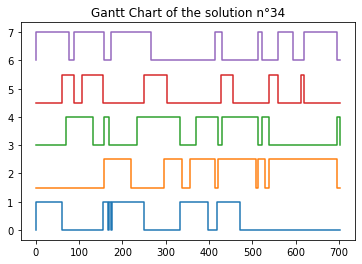

Makespan of the solution n°34 : 703
Regularity of the solution n°34 : 3482
Objective function of the solution n°34 : 2447846


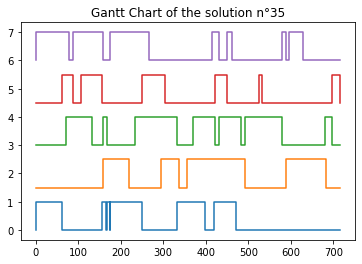

Makespan of the solution n°35 : 716
Regularity of the solution n°35 : 3470
Objective function of the solution n°35 : 2484520


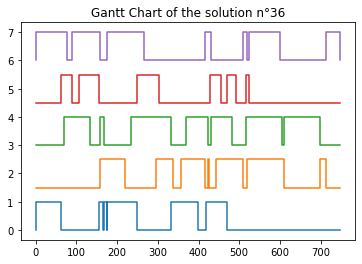

Makespan of the solution n°36 : 748
Regularity of the solution n°36 : 3456
Objective function of the solution n°36 : 2585088


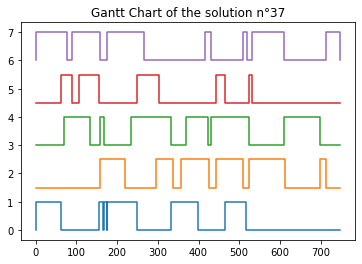

Makespan of the solution n°37 : 748
Regularity of the solution n°37 : 3460
Objective function of the solution n°37 : 2588080


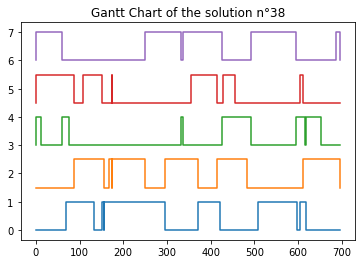

Makespan of the solution n°38 : 696
Regularity of the solution n°38 : 3520
Objective function of the solution n°38 : 2449920


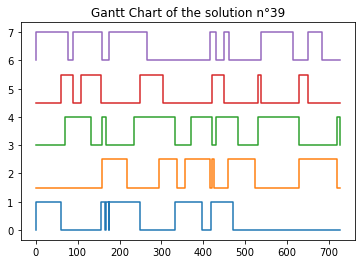

Makespan of the solution n°39 : 727
Regularity of the solution n°39 : 3510
Objective function of the solution n°39 : 2551770


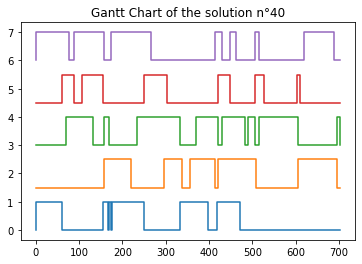

Makespan of the solution n°40 : 703
Regularity of the solution n°40 : 3542
Objective function of the solution n°40 : 2490026


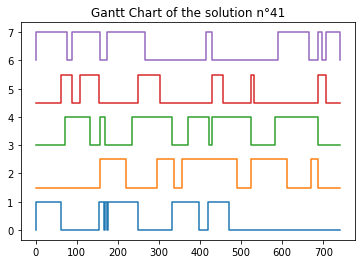

Makespan of the solution n°41 : 741
Regularity of the solution n°41 : 3510
Objective function of the solution n°41 : 2600910


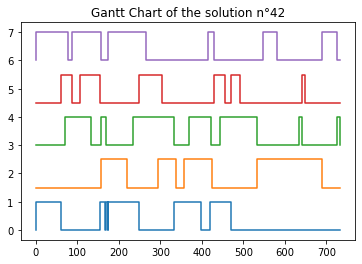

Makespan of the solution n°42 : 733
Regularity of the solution n°42 : 3546
Objective function of the solution n°42 : 2599218


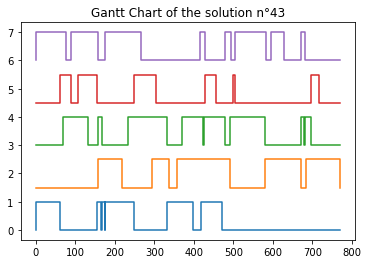

Makespan of the solution n°43 : 770
Regularity of the solution n°43 : 3552
Objective function of the solution n°43 : 2735040


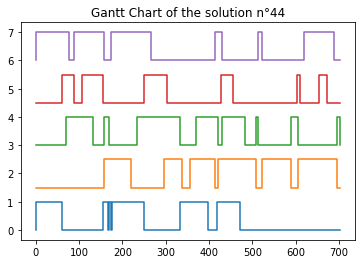

Makespan of the solution n°44 : 703
Regularity of the solution n°44 : 3632
Objective function of the solution n°44 : 2553296


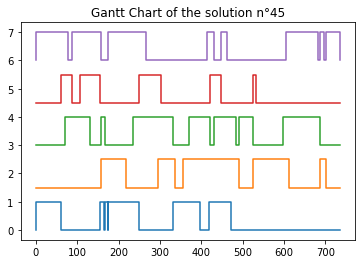

Makespan of the solution n°45 : 736
Regularity of the solution n°45 : 3604
Objective function of the solution n°45 : 2652544


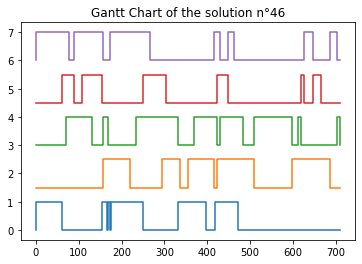

Makespan of the solution n°46 : 710
Regularity of the solution n°46 : 3678
Objective function of the solution n°46 : 2611380


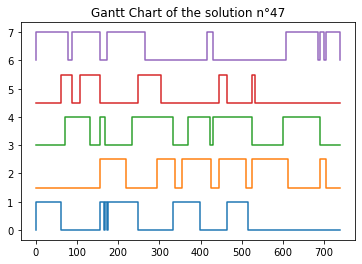

Makespan of the solution n°47 : 739
Regularity of the solution n°47 : 3660
Objective function of the solution n°47 : 2704740


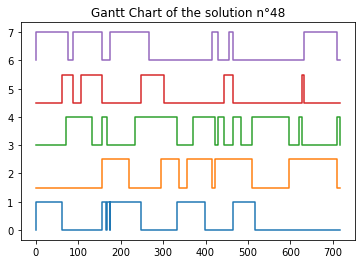

Makespan of the solution n°48 : 717
Regularity of the solution n°48 : 3696
Objective function of the solution n°48 : 2650032


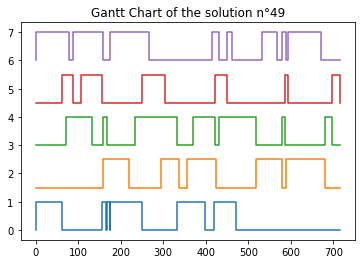

Makespan of the solution n°49 : 716
Regularity of the solution n°49 : 3702
Objective function of the solution n°49 : 2650632


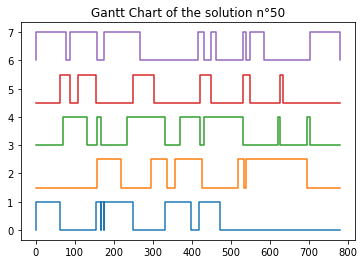

Makespan of the solution n°50 : 780
Regularity of the solution n°50 : 3662
Objective function of the solution n°50 : 2856360


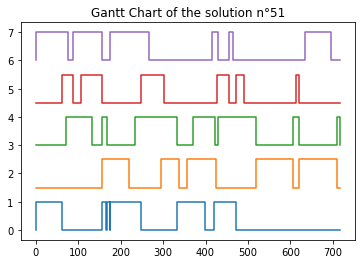

Makespan of the solution n°51 : 717
Regularity of the solution n°51 : 3728
Objective function of the solution n°51 : 2672976


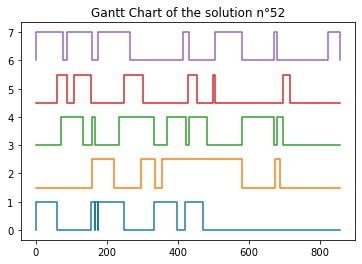

Makespan of the solution n°52 : 857
Regularity of the solution n°52 : 3598
Objective function of the solution n°52 : 3083486


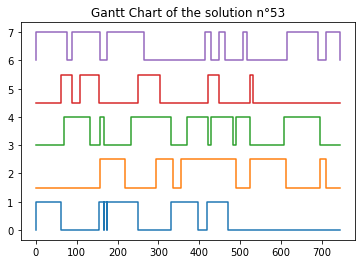

Makespan of the solution n°53 : 745
Regularity of the solution n°53 : 3712
Objective function of the solution n°53 : 2765440


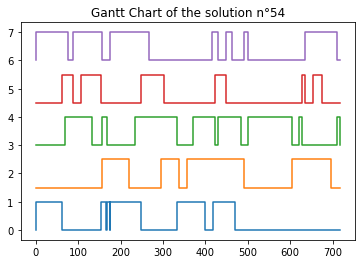

Makespan of the solution n°54 : 718
Regularity of the solution n°54 : 3774
Objective function of the solution n°54 : 2709732


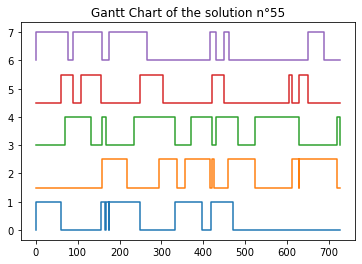

Makespan of the solution n°55 : 727
Regularity of the solution n°55 : 3802
Objective function of the solution n°55 : 2764054


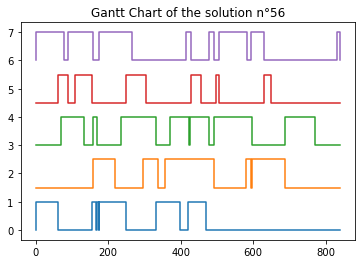

Makespan of the solution n°56 : 840
Regularity of the solution n°56 : 3728
Objective function of the solution n°56 : 3131520


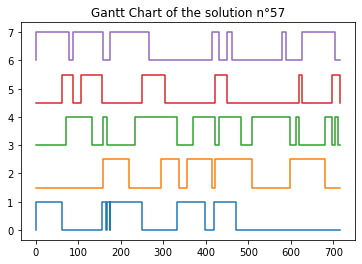

Makespan of the solution n°57 : 716
Regularity of the solution n°57 : 3878
Objective function of the solution n°57 : 2776648


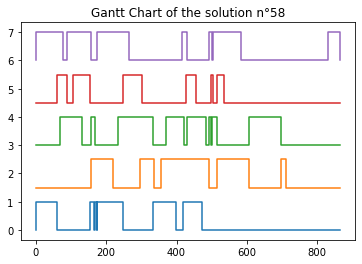

Makespan of the solution n°58 : 865
Regularity of the solution n°58 : 3730
Objective function of the solution n°58 : 3226450


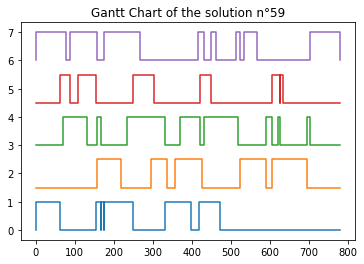

Makespan of the solution n°59 : 780
Regularity of the solution n°59 : 3826
Objective function of the solution n°59 : 2984280


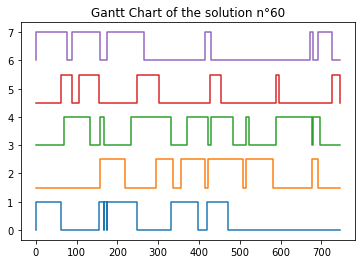

Makespan of the solution n°60 : 746
Regularity of the solution n°60 : 3870
Objective function of the solution n°60 : 2887020


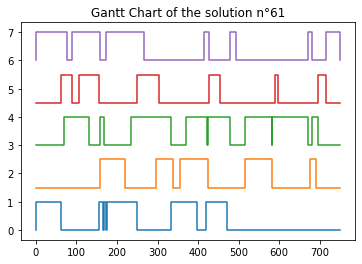

Makespan of the solution n°61 : 750
Regularity of the solution n°61 : 3878
Objective function of the solution n°61 : 2908500


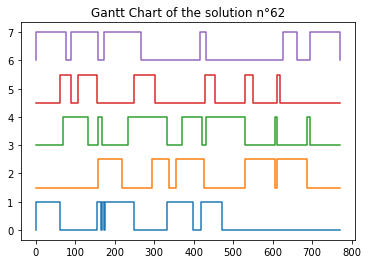

Makespan of the solution n°62 : 771
Regularity of the solution n°62 : 3888
Objective function of the solution n°62 : 2997648


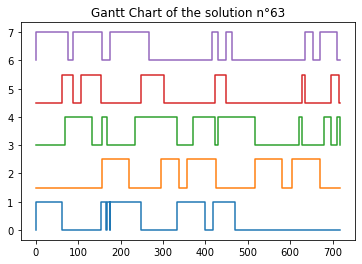

Makespan of the solution n°63 : 718
Regularity of the solution n°63 : 3942
Objective function of the solution n°63 : 2830356


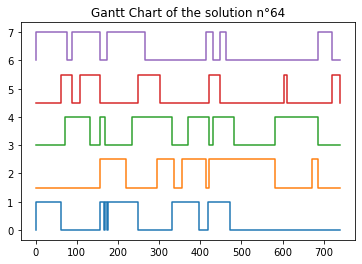

Makespan of the solution n°64 : 740
Regularity of the solution n°64 : 3928
Objective function of the solution n°64 : 2906720


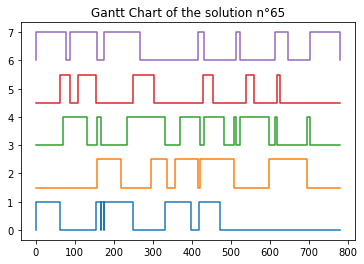

Makespan of the solution n°65 : 780
Regularity of the solution n°65 : 3892
Objective function of the solution n°65 : 3035760


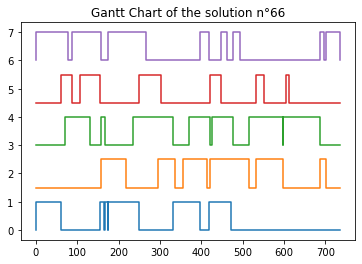

Makespan of the solution n°66 : 736
Regularity of the solution n°66 : 3980
Objective function of the solution n°66 : 2929280


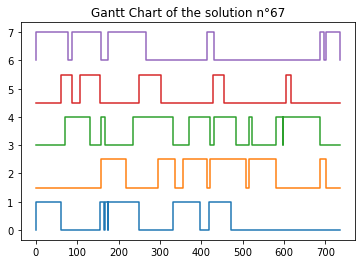

Makespan of the solution n°67 : 736
Regularity of the solution n°67 : 3990
Objective function of the solution n°67 : 2936640


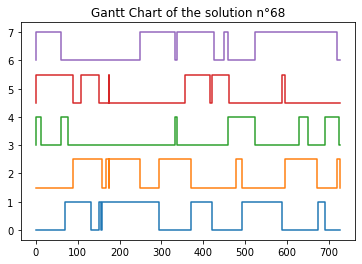

Makespan of the solution n°68 : 727
Regularity of the solution n°68 : 4020
Objective function of the solution n°68 : 2922540


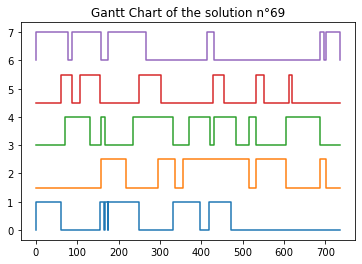

Makespan of the solution n°69 : 736
Regularity of the solution n°69 : 4022
Objective function of the solution n°69 : 2960192


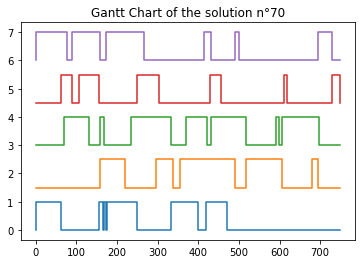

Makespan of the solution n°70 : 749
Regularity of the solution n°70 : 4046
Objective function of the solution n°70 : 3030454


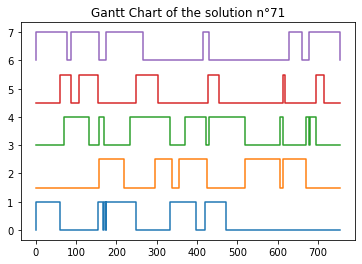

Makespan of the solution n°71 : 755
Regularity of the solution n°71 : 4044
Objective function of the solution n°71 : 3053220


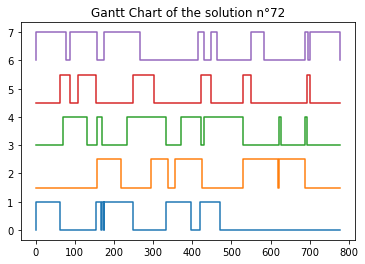

Makespan of the solution n°72 : 778
Regularity of the solution n°72 : 4024
Objective function of the solution n°72 : 3130672


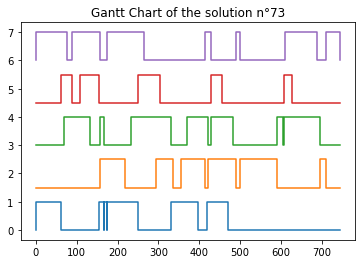

Makespan of the solution n°73 : 745
Regularity of the solution n°73 : 4062
Objective function of the solution n°73 : 3026190


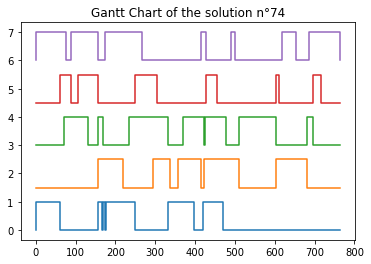

Makespan of the solution n°74 : 764
Regularity of the solution n°74 : 4048
Objective function of the solution n°74 : 3092672


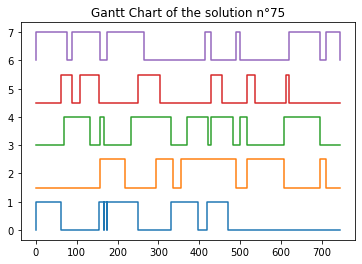

Makespan of the solution n°75 : 745
Regularity of the solution n°75 : 4094
Objective function of the solution n°75 : 3050030


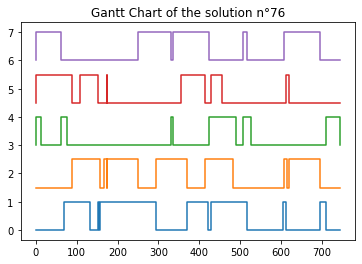

Makespan of the solution n°76 : 745
Regularity of the solution n°76 : 4094
Objective function of the solution n°76 : 3050030


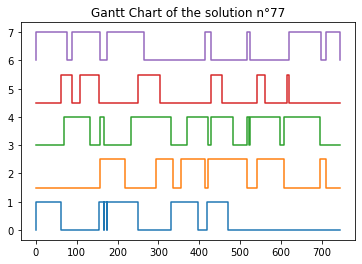

Makespan of the solution n°77 : 745
Regularity of the solution n°77 : 4102
Objective function of the solution n°77 : 3055990


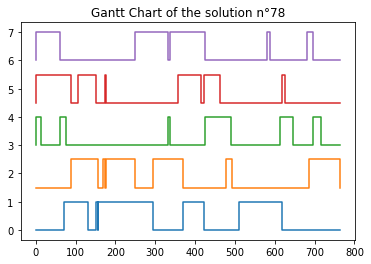

Makespan of the solution n°78 : 764
Regularity of the solution n°78 : 4094
Objective function of the solution n°78 : 3127816


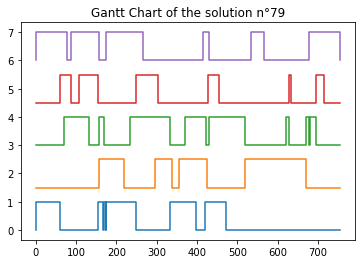

Makespan of the solution n°79 : 755
Regularity of the solution n°79 : 4104
Objective function of the solution n°79 : 3098520


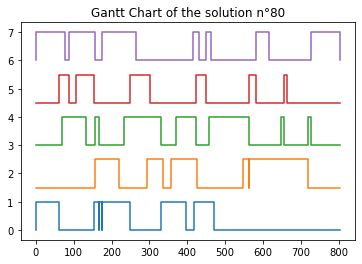

Makespan of the solution n°80 : 804
Regularity of the solution n°80 : 4062
Objective function of the solution n°80 : 3265848


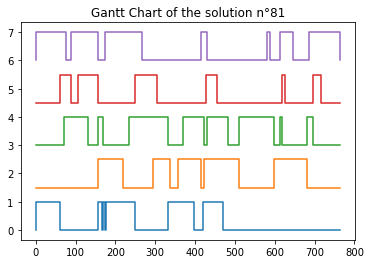

Makespan of the solution n°81 : 764
Regularity of the solution n°81 : 4108
Objective function of the solution n°81 : 3138512


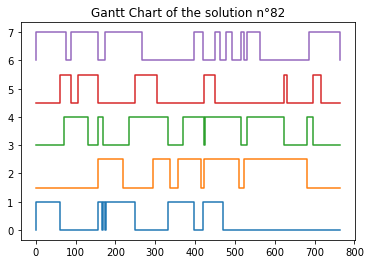

Makespan of the solution n°82 : 764
Regularity of the solution n°82 : 4114
Objective function of the solution n°82 : 3143096


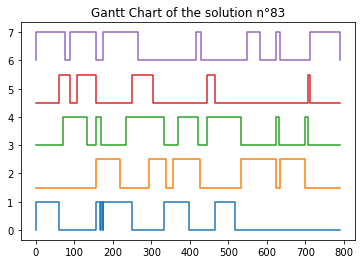

Makespan of the solution n°83 : 790
Regularity of the solution n°83 : 4120
Objective function of the solution n°83 : 3254800


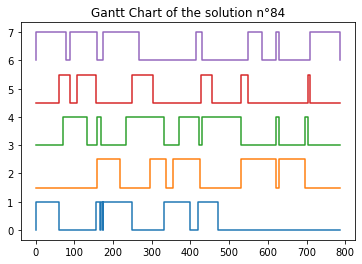

Makespan of the solution n°84 : 787
Regularity of the solution n°84 : 4146
Objective function of the solution n°84 : 3262902


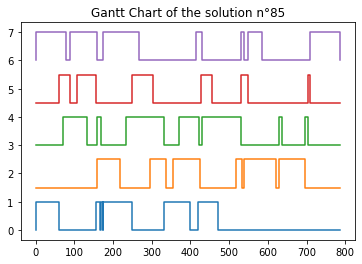

Makespan of the solution n°85 : 787
Regularity of the solution n°85 : 4146
Objective function of the solution n°85 : 3262902


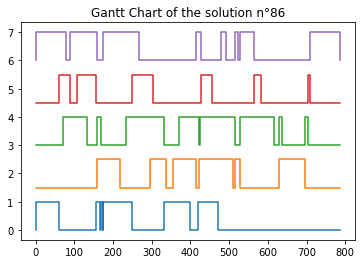

Makespan of the solution n°86 : 787
Regularity of the solution n°86 : 4154
Objective function of the solution n°86 : 3269198


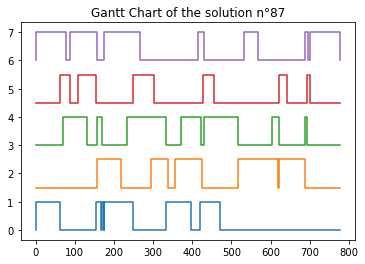

Makespan of the solution n°87 : 778
Regularity of the solution n°87 : 4266
Objective function of the solution n°87 : 3318948


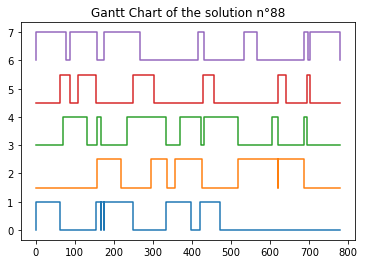

Makespan of the solution n°88 : 779
Regularity of the solution n°88 : 4270
Objective function of the solution n°88 : 3326330


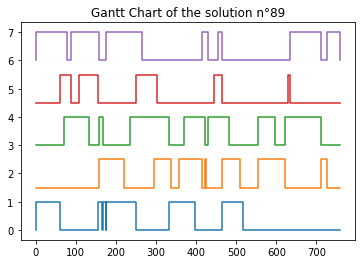

Makespan of the solution n°89 : 759
Regularity of the solution n°89 : 4298
Objective function of the solution n°89 : 3262182


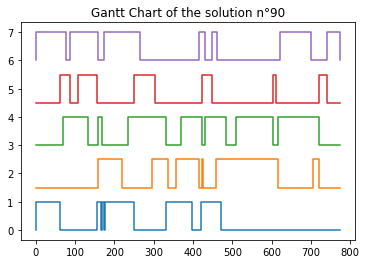

Makespan of the solution n°90 : 774
Regularity of the solution n°90 : 4288
Objective function of the solution n°90 : 3318912


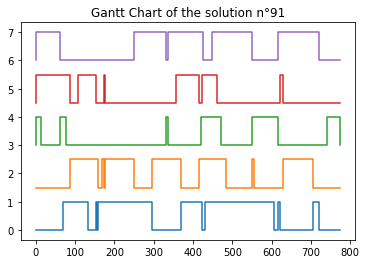

Makespan of the solution n°91 : 774
Regularity of the solution n°91 : 4316
Objective function of the solution n°91 : 3340584


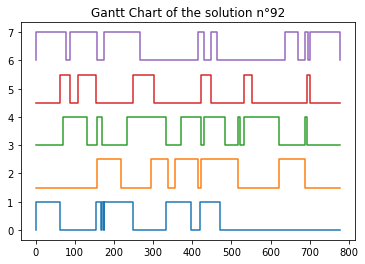

Makespan of the solution n°92 : 778
Regularity of the solution n°92 : 4318
Objective function of the solution n°92 : 3359404


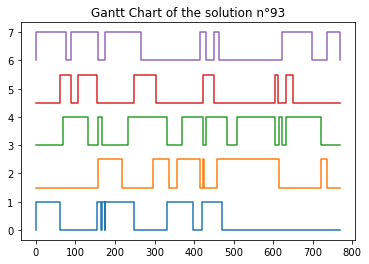

Makespan of the solution n°93 : 769
Regularity of the solution n°93 : 4332
Objective function of the solution n°93 : 3331308


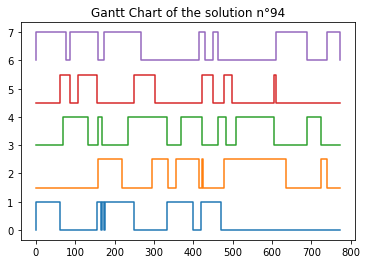

Makespan of the solution n°94 : 773
Regularity of the solution n°94 : 4356
Objective function of the solution n°94 : 3367188


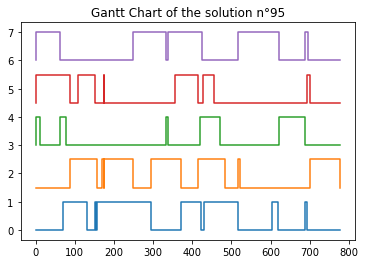

Makespan of the solution n°95 : 778
Regularity of the solution n°95 : 4398
Objective function of the solution n°95 : 3421644


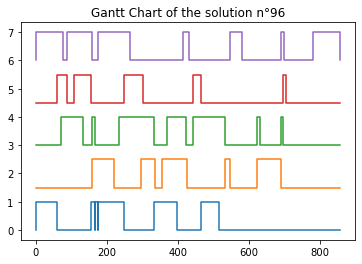

Makespan of the solution n°96 : 857
Regularity of the solution n°96 : 4322
Objective function of the solution n°96 : 3703954


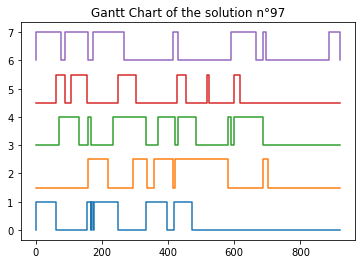

Makespan of the solution n°97 : 920
Regularity of the solution n°97 : 4286
Objective function of the solution n°97 : 3943120


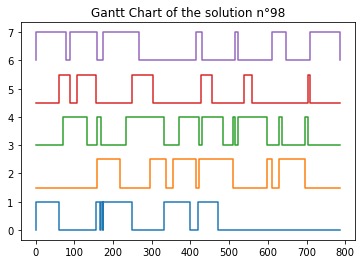

Makespan of the solution n°98 : 787
Regularity of the solution n°98 : 4426
Objective function of the solution n°98 : 3483262


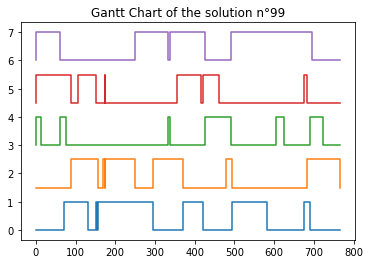

Makespan of the solution n°99 : 766
Regularity of the solution n°99 : 4476
Objective function of the solution n°99 : 3428616


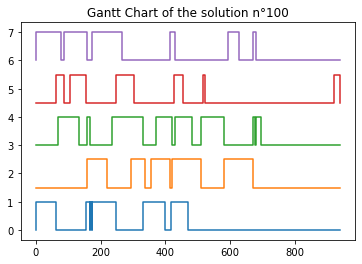

Makespan of the solution n°100 : 940
Regularity of the solution n°100 : 4338
Objective function of the solution n°100 : 4077720


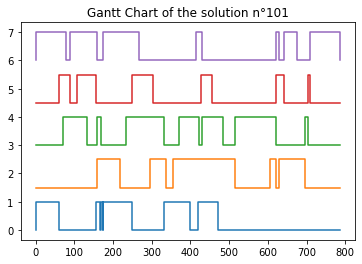

Makespan of the solution n°101 : 787
Regularity of the solution n°101 : 4510
Objective function of the solution n°101 : 3549370


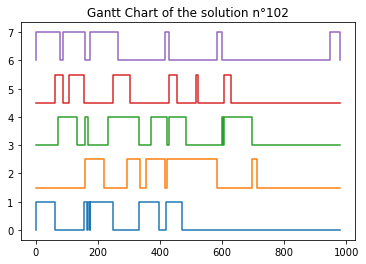

Makespan of the solution n°102 : 980
Regularity of the solution n°102 : 4326
Objective function of the solution n°102 : 4239480


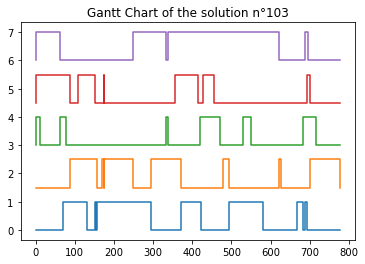

Makespan of the solution n°103 : 778
Regularity of the solution n°103 : 4586
Objective function of the solution n°103 : 3567908


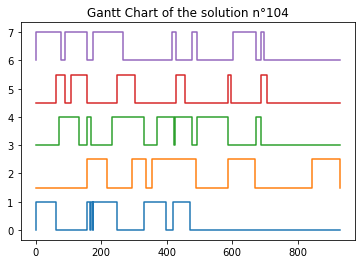

Makespan of the solution n°104 : 930
Regularity of the solution n°104 : 4520
Objective function of the solution n°104 : 4203600


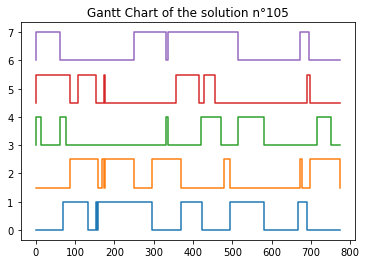

Makespan of the solution n°105 : 774
Regularity of the solution n°105 : 4686
Objective function of the solution n°105 : 3626964


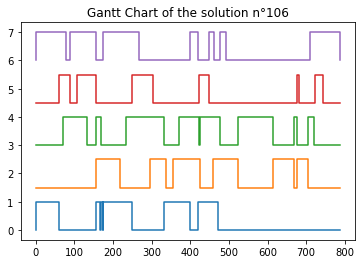

Makespan of the solution n°106 : 788
Regularity of the solution n°106 : 4692
Objective function of the solution n°106 : 3697296


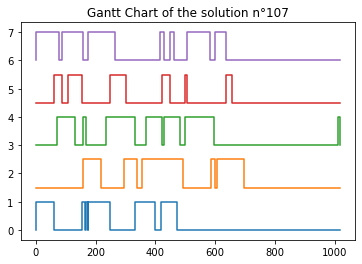

Makespan of the solution n°107 : 1018
Regularity of the solution n°107 : 4492
Objective function of the solution n°107 : 4572856


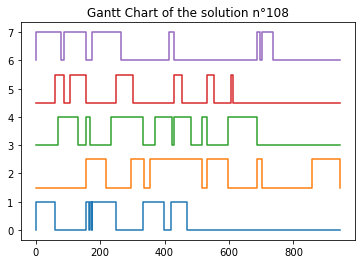

Makespan of the solution n°108 : 945
Regularity of the solution n°108 : 4606
Objective function of the solution n°108 : 4352670


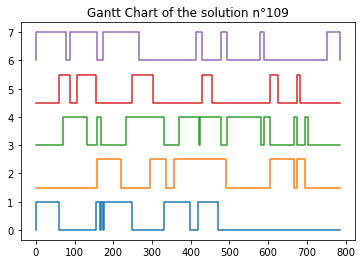

Makespan of the solution n°109 : 786
Regularity of the solution n°109 : 4794
Objective function of the solution n°109 : 3768084


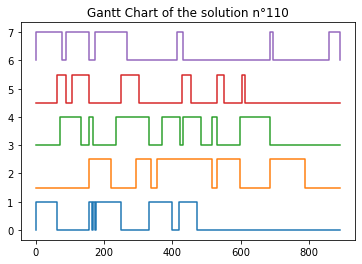

Makespan of the solution n°110 : 892
Regularity of the solution n°110 : 4772
Objective function of the solution n°110 : 4256624


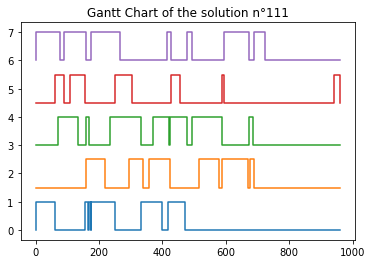

Makespan of the solution n°111 : 961
Regularity of the solution n°111 : 4742
Objective function of the solution n°111 : 4557062


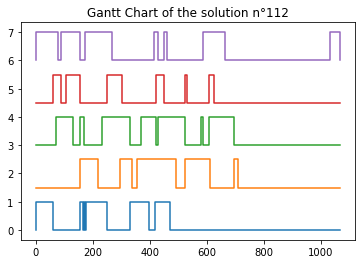

Makespan of the solution n°112 : 1069
Regularity of the solution n°112 : 4908
Objective function of the solution n°112 : 5246652


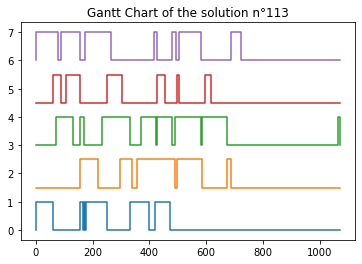

Makespan of the solution n°113 : 1071
Regularity of the solution n°113 : 4986
Objective function of the solution n°113 : 5340006


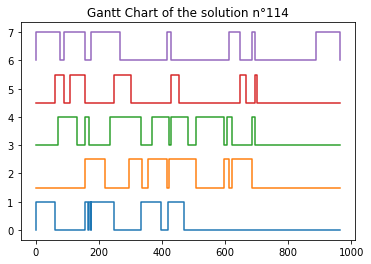

Makespan of the solution n°114 : 965
Regularity of the solution n°114 : 5146
Objective function of the solution n°114 : 4965890


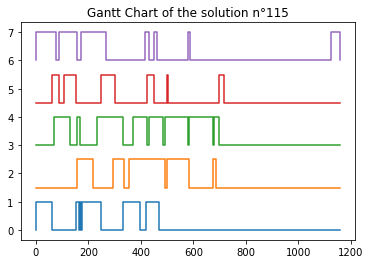

Makespan of the solution n°115 : 1159
Regularity of the solution n°115 : 5184
Objective function of the solution n°115 : 6008256


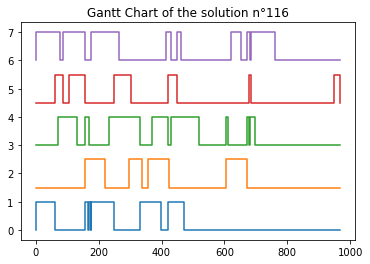

Makespan of the solution n°116 : 968
Regularity of the solution n°116 : 5382
Objective function of the solution n°116 : 5209776


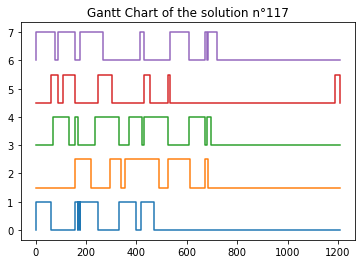

Makespan of the solution n°117 : 1209
Regularity of the solution n°117 : 5182
Objective function of the solution n°117 : 6265038


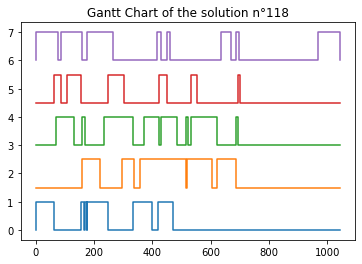

Makespan of the solution n°118 : 1044
Regularity of the solution n°118 : 5382
Objective function of the solution n°118 : 5618808


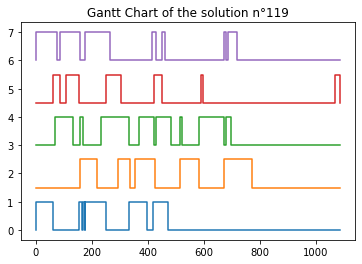

Makespan of the solution n°119 : 1087
Regularity of the solution n°119 : 5346
Objective function of the solution n°119 : 5811102


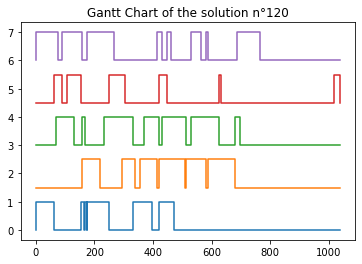

Makespan of the solution n°120 : 1039
Regularity of the solution n°120 : 5406
Objective function of the solution n°120 : 5616834


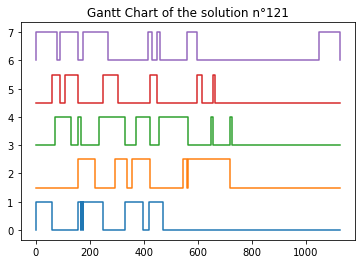

Makespan of the solution n°121 : 1128
Regularity of the solution n°121 : 5354
Objective function of the solution n°121 : 6039312


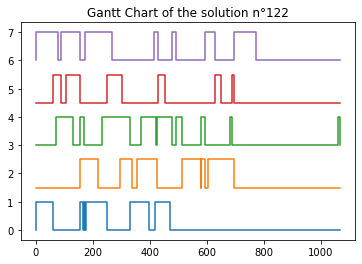

Makespan of the solution n°122 : 1069
Regularity of the solution n°122 : 5466
Objective function of the solution n°122 : 5843154


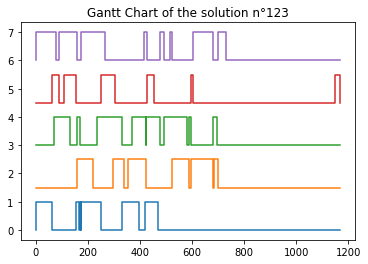

Makespan of the solution n°123 : 1169
Regularity of the solution n°123 : 5638
Objective function of the solution n°123 : 6590822


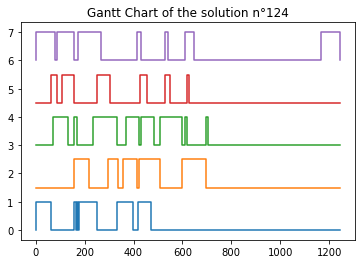

Makespan of the solution n°124 : 1245
Regularity of the solution n°124 : 5752
Objective function of the solution n°124 : 7161240


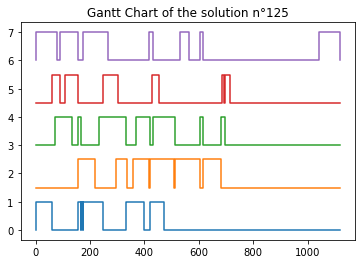

Makespan of the solution n°125 : 1120
Regularity of the solution n°125 : 5890
Objective function of the solution n°125 : 6596800


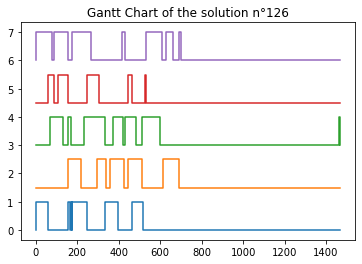

Makespan of the solution n°126 : 1468
Regularity of the solution n°126 : 6334
Objective function of the solution n°126 : 9298312


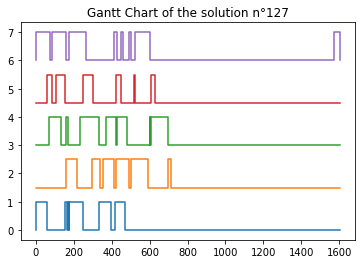

Makespan of the solution n°127 : 1605
Regularity of the solution n°127 : 6812
Objective function of the solution n°127 : 10933260


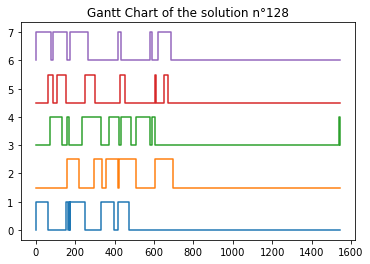

Makespan of the solution n°128 : 1545
Regularity of the solution n°128 : 7000
Objective function of the solution n°128 : 10815000


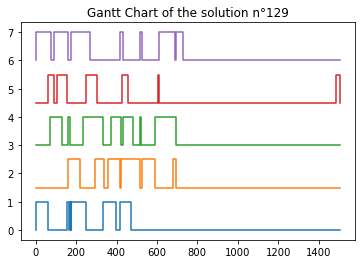

Makespan of the solution n°129 : 1507
Regularity of the solution n°129 : 7046
Objective function of the solution n°129 : 10618322


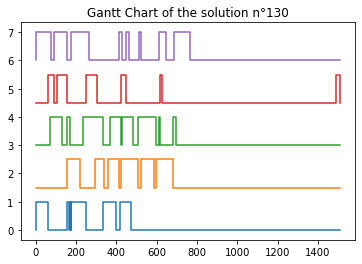

Makespan of the solution n°130 : 1511
Regularity of the solution n°130 : 7274
Objective function of the solution n°130 : 10991014


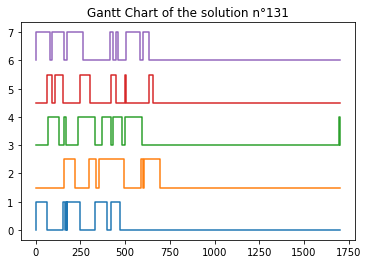

Makespan of the solution n°131 : 1703
Regularity of the solution n°131 : 7232
Objective function of the solution n°131 : 12316096


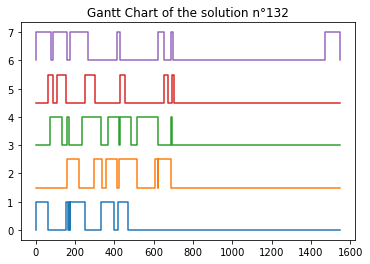

Makespan of the solution n°132 : 1549
Regularity of the solution n°132 : 7482
Objective function of the solution n°132 : 11589618


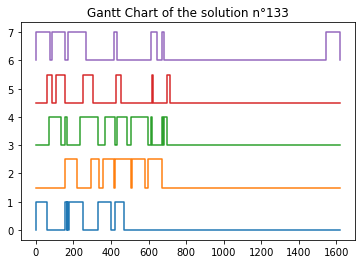

Makespan of the solution n°133 : 1620
Regularity of the solution n°133 : 7532
Objective function of the solution n°133 : 12201840


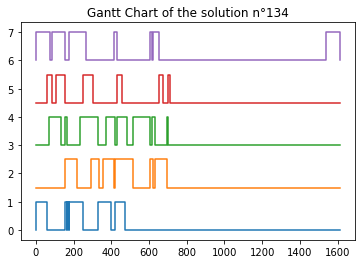

Makespan of the solution n°134 : 1613
Regularity of the solution n°134 : 7810
Objective function of the solution n°134 : 12597530


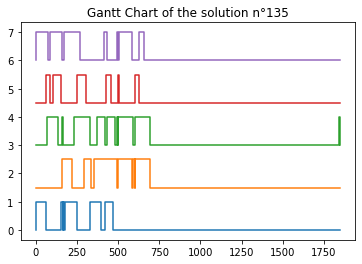

Makespan of the solution n°135 : 1848
Regularity of the solution n°135 : 7842
Objective function of the solution n°135 : 14492016


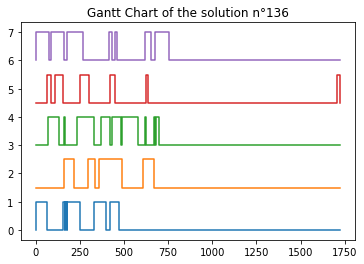

Makespan of the solution n°136 : 1724
Regularity of the solution n°136 : 8122
Objective function of the solution n°136 : 14002328


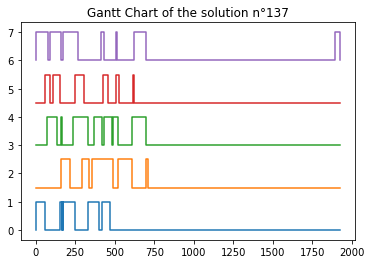

Makespan of the solution n°137 : 1926
Regularity of the solution n°137 : 8818
Objective function of the solution n°137 : 16983468


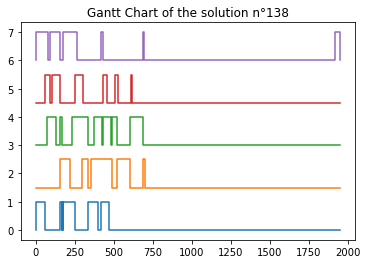

Makespan of the solution n°138 : 1950
Regularity of the solution n°138 : 8878
Objective function of the solution n°138 : 17312100


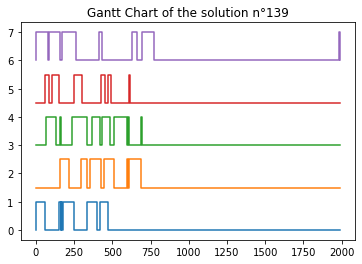

Makespan of the solution n°139 : 1990
Regularity of the solution n°139 : 8874
Objective function of the solution n°139 : 17659260


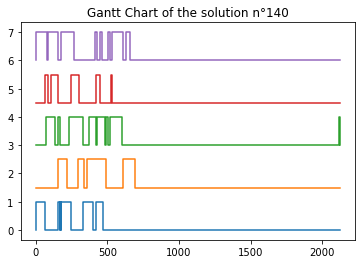

Makespan of the solution n°140 : 2126
Regularity of the solution n°140 : 8946
Objective function of the solution n°140 : 19019196


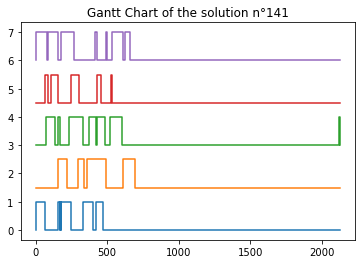

Makespan of the solution n°141 : 2130
Regularity of the solution n°141 : 8976
Objective function of the solution n°141 : 19118880


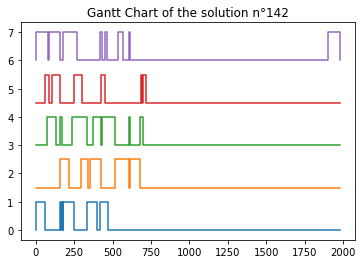

Makespan of the solution n°142 : 1982
Regularity of the solution n°142 : 9312
Objective function of the solution n°142 : 18456384


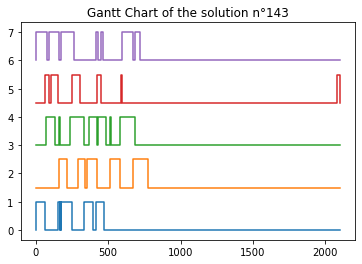

Makespan of the solution n°143 : 2103
Regularity of the solution n°143 : 9410
Objective function of the solution n°143 : 19789230


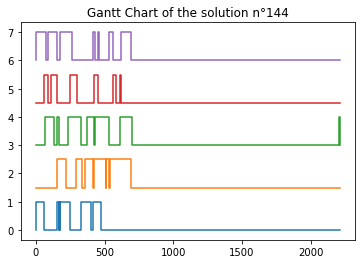

Makespan of the solution n°144 : 2214
Regularity of the solution n°144 : 9472
Objective function of the solution n°144 : 20971008


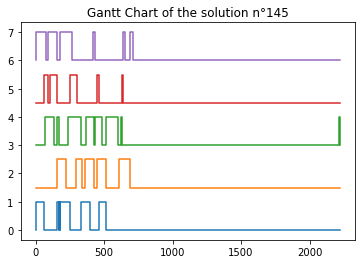

Makespan of the solution n°145 : 2224
Regularity of the solution n°145 : 9738
Objective function of the solution n°145 : 21657312


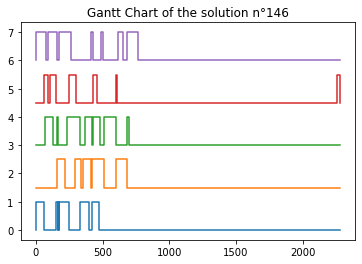

Makespan of the solution n°146 : 2281
Regularity of the solution n°146 : 10308
Objective function of the solution n°146 : 23512548


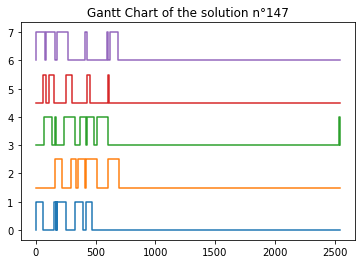

Makespan of the solution n°147 : 2547
Regularity of the solution n°147 : 10928
Objective function of the solution n°147 : 27833616


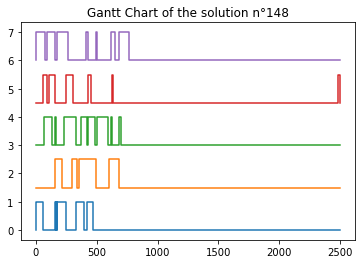

Makespan of the solution n°148 : 2500
Regularity of the solution n°148 : 11276
Objective function of the solution n°148 : 28190000


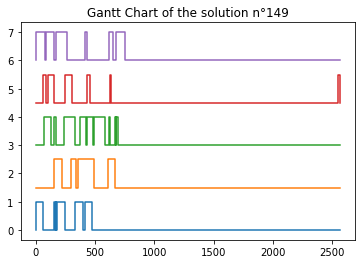

Makespan of the solution n°149 : 2566
Regularity of the solution n°149 : 11504
Objective function of the solution n°149 : 29519264


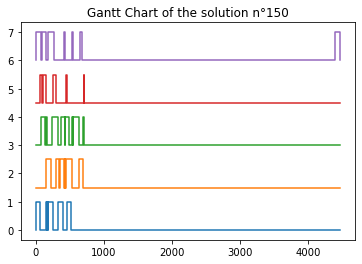

Makespan of the solution n°150 : 4466
Regularity of the solution n°150 : 19208
Objective function of the solution n°150 : 85782928


In [15]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))